# Study of the entropia on the entire model

In [1]:
%load_ext autoreload
%autoreload 2

INF = 1e30

import os
from os import path


# set the repository to the git repository
cwd = os.getcwd().split(os.path.sep)
while cwd[-1] != "stage_4_gm":
    os.chdir("..")
    cwd = os.getcwd().split(os.path.sep)
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from tqdm.notebook import tqdm
from torch_set_up import DEVICE
from training_bert import BertNliLight
from regularize_training_bert import SNLIDataModule
from attention_algorithms.attention_metrics import default_plot_colormap

## The data

In [2]:
data_dir = os.path.join(".cache", "raw_data", "e_snli")

dm = SNLIDataModule(cache=data_dir,
                   batch_size = 4,
                   num_workers = 4,
                   nb_data = 999 # multiple of three for the consistency
                   )

dm.prepare_data()

dm.setup(stage="test")

test_dataset = dm.test_set
test_dataloader = dm.test_dataloader()

## The entropia for each head of each layer

### With punctuation

In [6]:
mean_calculus = np.zeros((12, 12))
softmax_calculus = np.zeros((12, 12))

buff = np.zeros((12, 12))

ckp = path.join(".cache", "logs", "igrida_trained", "0", "best.ckpt")
model = BertNliLight.load_from_checkpoint(ckp)
model = model.eval()


with torch.no_grad():
    model = model.to(DEVICE)
    pbar = tqdm(enumerate(test_dataloader), total = int(len(test_dataset)/4))
    for id_batch, batch in pbar:
        
        pbar.set_description("proceed the entropy maps")

        ids = batch["input_ids"].to(DEVICE)
        mk = batch["attention_masks"].to(DEVICE)
        target = torch.tensor([0, 101, 102]).to(DEVICE)

        # process the mask for the specials tokens
        spe_tok_mask = torch.isin(ids, target).type(torch.uint8)
        spe_tok_mask = spe_tok_mask.unsqueeze(1).unsqueeze(1).repeat(1,12,12,1)

        # number of tokens in the sentence
        nb_tokens = mk.sum(dim=-1) - 3 # the number of tokens in the sentence -3 for the specials tokens
        nb_tokens = nb_tokens.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1).repeat(1, 12, 12, 150)
        
        output = model(
            input_ids = ids,
            attention_mask = mk
        )

        # process the attention tensor
        attention_tensor = torch.stack(output["outputs"].attentions, dim=1) # shape [b, l, h, T, T]
        pad = torch.tensor([0]).to(DEVICE)
        pad_mask = torch.logical_not(torch.isin(ids, pad)).type(torch.uint8).unsqueeze(1).unsqueeze(1).unsqueeze(1).repeat(1, 12, 12, 150, 1)
        pad_mask = torch.transpose(pad_mask, dim0=3, dim1=4)
        attention_tensor = torch.mul(attention_tensor, pad_mask) # put to zero all the attention over the paddings
        
        log_t = torch.log((1-spe_tok_mask).sum(dim=-1)) # sent log len
        
        # softmax calculus
        a_hat = attention_tensor.sum(dim=3) # sum over the lines
            # normalization --> sum to one
        a_hat = torch.softmax(a_hat - INF * spe_tok_mask, dim=-1)
        softmax_calculus += ((-a_hat * torch.log(a_hat + 1e-16)).sum(dim=-1) / log_t).sum(dim=0).cpu().numpy()
        

        # mean calculus
        a_hat = attention_tensor.sum(dim=3) # sum over the lines
            # normalization --> sum to one
        a_hat /= nb_tokens
        a_hat = torch.mul(a_hat, 1-spe_tok_mask)
        # first sum to get the entropy second sum, to sum over the batch
        mean_calculus += ((-a_hat * torch.log(a_hat + 1e-16)).sum(dim=-1) / log_t).sum(dim=0).cpu().numpy()

        
model = model.cpu()
del model
torch.cuda.empty_cache()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/249 [00:00<?, ?it/s]

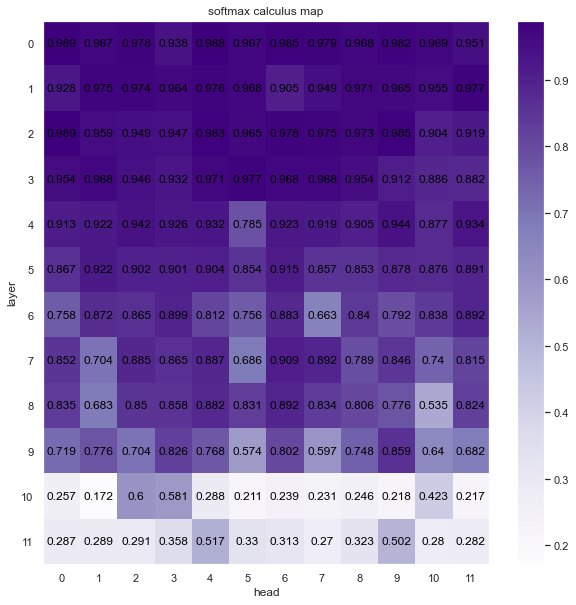

In [7]:
softmax_fig = default_plot_colormap(map = softmax_calculus/999,
                                    xlabel = "head",
                                    ylabel = "layer",
                                    title = "softmax calculus map")

plt.savefig(os.path.join(os.getcwd(),".cache","plots","entropy_study", "softmax_entropy_with_punctuation_map.png"))

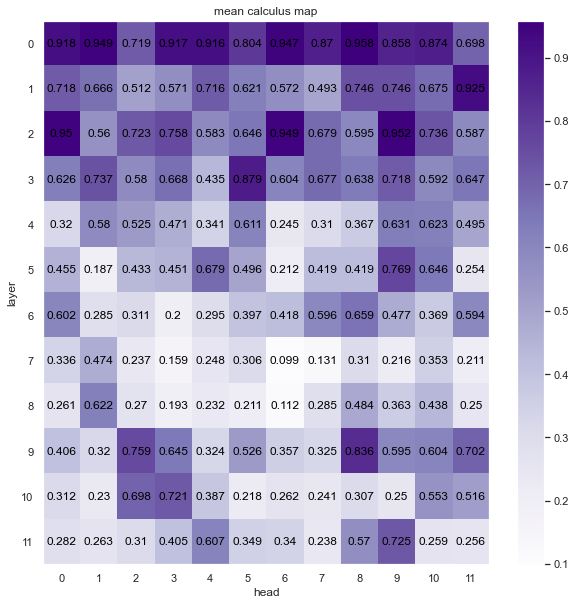

In [8]:
mean_fig = default_plot_colormap(map = mean_calculus/999,
                                    xlabel = "head",
                                    ylabel = "layer",
                                    title = "mean calculus map")

plt.savefig(os.path.join(os.getcwd(),".cache","plots","entropy_study", "mean_entropy_with_punctuation_map.png"))

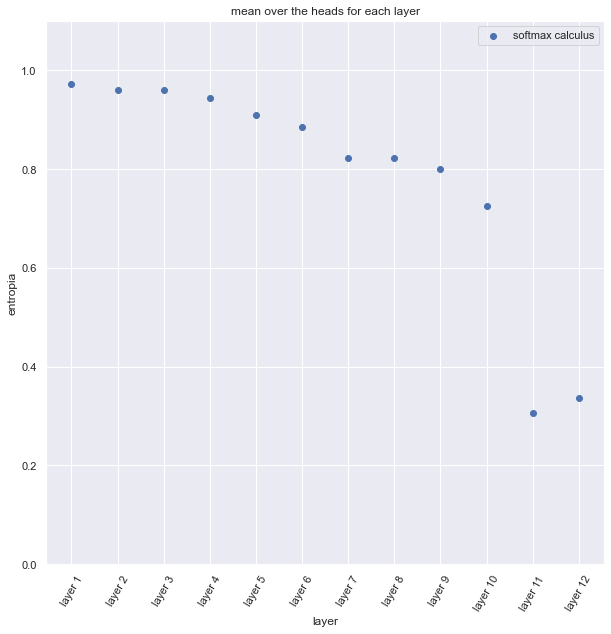

In [10]:
fig = plt.figure(figsize=(10,10))

txt = plt.title("mean over the heads for each layer")

plt.scatter(list(range(1,13)), np.sum(softmax_calculus/999, axis=-1)/12, label="softmax calculus")
#plt.scatter(list(range(1,13)), np.sum(mean_calculus/999, axis=-1)/12, label="mean calculus")

plt.ylim((0, 1.1))

plt.ylabel("entropia")
plt.xlabel("layer")

x = list(range(1, 13))
plt.xticks(x, [f"layer {l}" for l in x], rotation=60)

txt = plt.legend()
plt.savefig(os.path.join(os.getcwd(),".cache","plots","entropy_study", "mean_over_layer_with_punctuations_map.png"))

### Without punctuation

In [11]:
mean_calculus = np.zeros((12, 12))
softmax_calculus = np.zeros((12, 12))

buff = np.zeros((12, 12))

ckp = path.join(".cache", "logs", "igrida_trained", "0", "best.ckpt")
model = BertNliLight.load_from_checkpoint(ckp)
model = model.eval()


with torch.no_grad():
    model = model.to(DEVICE)
    pbar = tqdm(enumerate(test_dataloader), total = int(len(test_dataset)/4))
    for id_batch, batch in pbar:

        pbar.set_description("proceed the entropy maps")

        ids = batch["input_ids"].to(DEVICE)
        mk = batch["attention_masks"].to(DEVICE)
        target = torch.tensor(list(range(999, 1014)) + [0, 101, 102]).to(DEVICE)

        # process the mask for the specials tokens
        spe_tok_mask = torch.isin(ids, target).type(torch.uint8)
        spe_tok_mask = spe_tok_mask.unsqueeze(1).unsqueeze(1).repeat(1,12,12,1)

        # the number of tokens in the sentence
        count = torch.tensor(list(range(999, 1014)) + [101, 102]).to(DEVICE)
        nb_tokens = mk.sum(dim=-1) - torch.isin(ids, count).sum(dim=-1) # the number of tokens in the sentence -3 for the specials tokens
        nb_tokens = nb_tokens.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1).repeat(1, 12, 12, 150)

        output = model(
            input_ids = ids,
            attention_mask = mk
        )

        # process the attention tensor
        attention_tensor = torch.stack(output["outputs"].attentions, dim=1) # shape [b, l, h, T, T]
        pad = torch.tensor([0]).to(DEVICE)
        pad_mask = torch.logical_not(torch.isin(ids, pad)).type(torch.uint8).unsqueeze(1).unsqueeze(1).unsqueeze(1).repeat(1, 12, 12, 150, 1)
        pad_mask = torch.transpose(pad_mask, dim0=3, dim1=4)
        attention_tensor = torch.mul(attention_tensor, pad_mask) # put to zero all the attention over the paddings
        
        log_t = torch.log((1-spe_tok_mask).sum(dim=-1)) # sent log len
        
        # softmax calculus
        a_hat = attention_tensor.sum(dim=3) # sum over the lines
            # normalization --> sum to one
        a_hat = torch.softmax(a_hat - INF * spe_tok_mask, dim=-1)
        softmax_calculus += ((-a_hat * torch.log(a_hat + 1e-16)).sum(dim=-1) / log_t).sum(dim=0).cpu().numpy()
        

        # mean calculus
        a_hat = attention_tensor.sum(dim=3) # sum over the lines
            # normalization --> sum to one
        a_hat /= nb_tokens
        a_hat = torch.mul(a_hat, 1-spe_tok_mask)
        # first sum to get the entropy second sum, to sum over the batch
        mean_calculus += ((-a_hat * torch.log(a_hat + 1e-16)).sum(dim=-1) / log_t).sum(dim=0).cpu().numpy()


model = model.cpu()
del model
torch.cuda.empty_cache()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/249 [00:00<?, ?it/s]

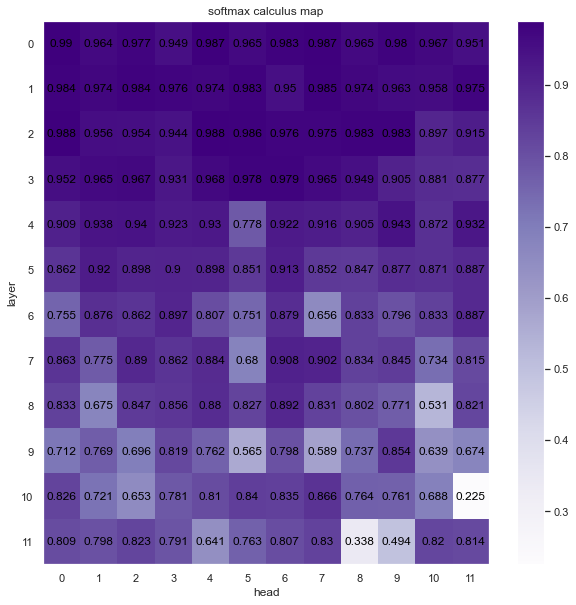

In [12]:
softmax_fig = default_plot_colormap(map = softmax_calculus/999,
                                    xlabel = "head",
                                    ylabel = "layer",
                                    title = "softmax calculus map")

plt.savefig(os.path.join(os.getcwd(),".cache","plots","entropy_study", "softmax_entropy_punctuation_less_map.png"))

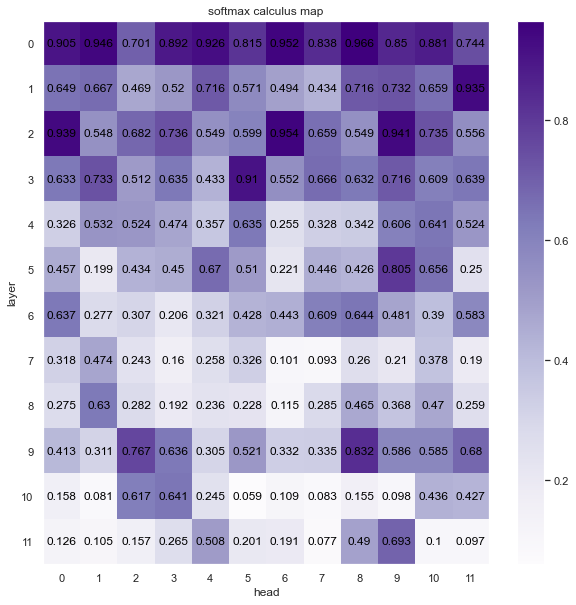

In [13]:
mean_fig = default_plot_colormap(map = mean_calculus/999,
                                    xlabel = "head",
                                    ylabel = "layer",
                                    title = "softmax calculus map")

plt.savefig(os.path.join(os.getcwd(),".cache","plots","entropy_study", "mean_entropy_punctuation_less_map.png"))

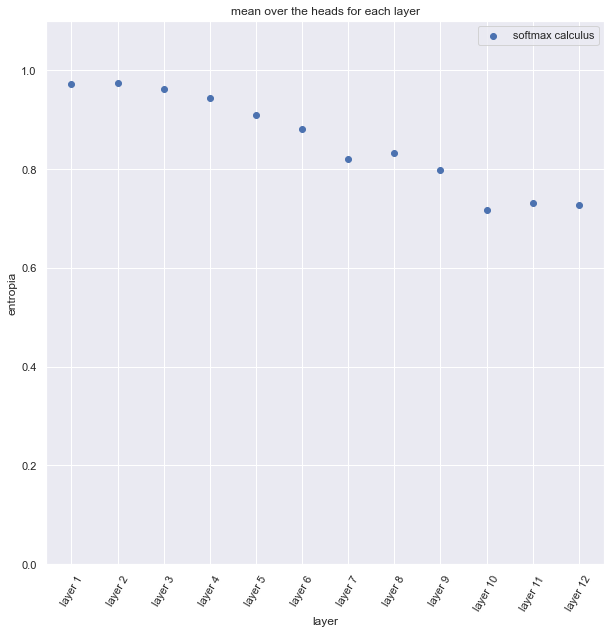

In [15]:
fig = plt.figure(figsize=(10,10))

txt = plt.title("mean over the heads for each layer")

plt.scatter(list(range(1,13)), np.sum(softmax_calculus/999, axis=-1)/12, label="softmax calculus")
#plt.scatter(list(range(1,13)), np.sum(mean_calculus/999, axis=-1)/12, label="mean calculus")

plt.ylim((0, 1.1))

plt.ylabel("entropia")
plt.xlabel("layer")

x = list(range(1, 13))
plt.xticks(x, [f"layer {l}" for l in x], rotation=60)

txt = plt.legend()
plt.savefig(os.path.join(os.getcwd(),".cache","plots","entropy_study", "mean_over_layer_punctuation_less_map.png"))

## The entropia by agregation of the heads on each layers

### With the punctuation

In [3]:
mean_calculus = np.zeros((12, 1))
softmax_calculus = np.zeros((12, 1))

buff = np.zeros((12, 12))

ckp = path.join(".cache", "logs", "igrida_trained", "0", "best.ckpt")
model = BertNliLight.load_from_checkpoint(ckp)
model = model.eval()


with torch.no_grad():
    model = model.to(DEVICE)
    pbar = tqdm(enumerate(test_dataloader), total = int(len(test_dataset)/4))
    for id_batch, batch in pbar:

        pbar.set_description("proceed the entropy maps")

        ids = batch["input_ids"].to(DEVICE)
        mk = batch["attention_masks"].to(DEVICE)
        target = torch.tensor([0, 101, 102]).to(DEVICE)

        # process the mask for the specials tokens
        spe_tok_mask = torch.isin(ids, target).type(torch.uint8)
        spe_tok_mask = spe_tok_mask.unsqueeze(1).repeat(1,12,1) # repeat along the different layers

        # number of tokens in the sentence
        nb_tokens = mk.sum(dim=-1) - 3 # the number of tokens in the sentence -3 for the specials tokens
        nb_tokens = nb_tokens.unsqueeze(-1).unsqueeze(-1).repeat(1, 12, 150)

        output = model(
            input_ids = ids,
            attention_mask = mk
        )

        # process the attention tensor
        attention_tensor = torch.stack(output["outputs"].attentions, dim=1) # shape [b, l, h, T, T]
        pad = torch.tensor([0]).to(DEVICE)
        pad_mask = torch.logical_not(torch.isin(ids, pad)).type(torch.uint8).unsqueeze(1).unsqueeze(1).unsqueeze(1).repeat(1, 12, 12, 150, 1)
        pad_mask = torch.transpose(pad_mask, dim0=3, dim1=4)
        attention_tensor = torch.mul(attention_tensor, pad_mask) # put to zero all the attention over the paddings
        attention_tensor = attention_tensor.sum(dim=2)/12
        
        log_t = torch.log((1-spe_tok_mask).sum(dim=-1)) # sent log len
        # softmax calculus
        a_hat = attention_tensor.sum(dim=2) # sum over the lines
            # normalization --> sum to one
        a_hat = torch.softmax(a_hat - INF * spe_tok_mask, dim=-1)
        softmax_calculus[:, 0] += ((-a_hat * torch.log(a_hat + 1e-16)).sum(dim=-1) / log_t).sum(dim=0).cpu().numpy()
        

        # mean calculus
        a_hat = attention_tensor.sum(dim=2) # sum over the lines
            # normalization --> sum to one
        a_hat /= nb_tokens
        a_hat = torch.mul(a_hat, 1-spe_tok_mask)
        # first sum to get the entropy second sum, to sum over the batch
        mean_calculus[:, 0] += ((-a_hat * torch.log(a_hat + 1e-16)).sum(dim=-1) / log_t).sum(dim=0).cpu().numpy()


model = model.cpu()
del model
torch.cuda.empty_cache()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/249 [00:00<?, ?it/s]

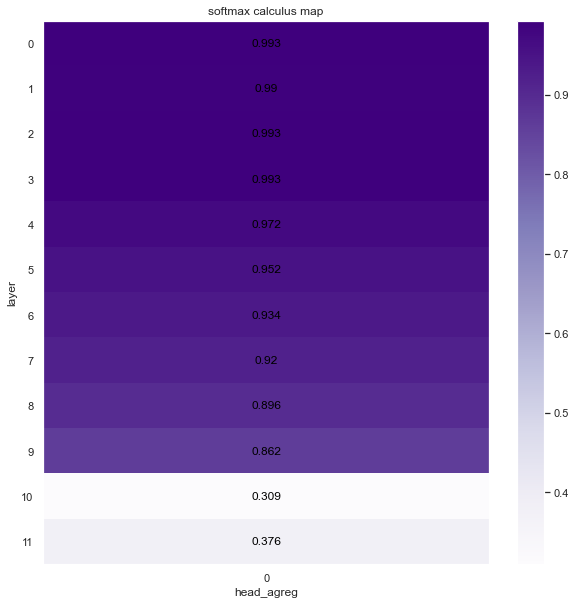

In [4]:
softmax_fig = default_plot_colormap(map = softmax_calculus/999,
                                    xlabel = "head_agreg",
                                    ylabel = "layer",
                                    title = "softmax calculus map")

plt.savefig(os.path.join(os.getcwd(),".cache","plots","entropy_study", "softmax_entropy_with_punctuation_head_agreg_map.png"))

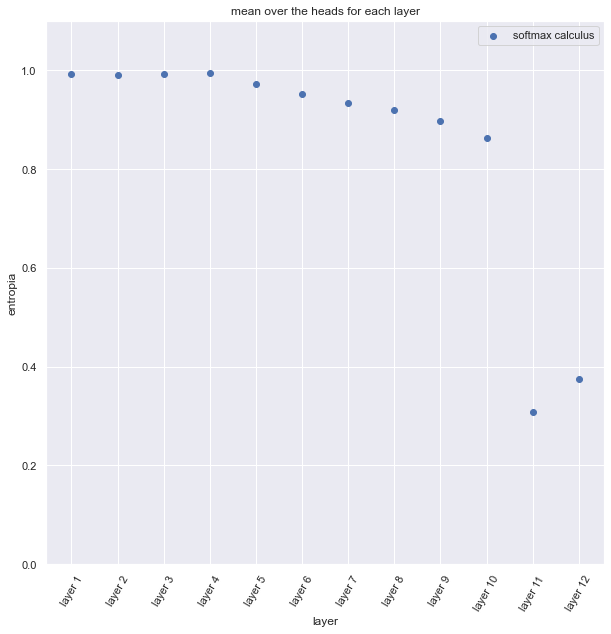

In [6]:
fig = plt.figure(figsize=(10,10))

txt = plt.title("mean over the heads for each layer")

plt.scatter(list(range(1,13)), softmax_calculus[:, 0]/999, label="softmax calculus")
#plt.scatter(list(range(1,13)), mean_calculus[:, 0]/999, label="softmax calculus")
plt.ylim((0, 1.1))

plt.ylabel("entropia")
plt.xlabel("layer")

x = list(range(1, 13))
plt.xticks(x, [f"layer {l}" for l in x], rotation=60)

txt = plt.legend()
plt.savefig(os.path.join(os.getcwd(),".cache","plots","entropy_study", "mean_head_agregation_entropia_scatter.png"))

### Punctuation less

In [7]:
mean_calculus = np.zeros((12, 1))
softmax_calculus = np.zeros((12, 1))

buff = np.zeros((12, 12))

ckp = path.join(".cache", "logs", "igrida_trained", "0", "best.ckpt")
model = BertNliLight.load_from_checkpoint(ckp)
model = model.eval()


with torch.no_grad():
    model = model.to(DEVICE)
    pbar = tqdm(enumerate(test_dataloader), total = int(len(test_dataset)/4))
    for id_batch, batch in pbar:

        pbar.set_description("proceed the entropy maps")

        ids = batch["input_ids"].to(DEVICE)
        mk = batch["attention_masks"].to(DEVICE)
        target = torch.tensor(list(range(999, 1014)) + [0, 101, 102]).to(DEVICE) # in the specials tokens put the punctuation

        # process the mask for the specials tokens
        spe_tok_mask = torch.isin(ids, target).type(torch.uint8)
        spe_tok_mask = spe_tok_mask.unsqueeze(1).repeat(1,12,1) # repeat along the different heads

        # number of tokens in the sentence
        nb_tokens = mk.sum(dim=-1) - 3 # the number of tokens in the sentence -3 for the specials tokens
        nb_tokens = nb_tokens.unsqueeze(-1).unsqueeze(-1).repeat(1, 12, 150)

        output = model(
            input_ids = ids,
            attention_mask = mk
        )

        # process the attention tensor
        attention_tensor = torch.stack(output["outputs"].attentions, dim=1) # shape [b, l, h, T, T]
        pad = torch.tensor([0]).to(DEVICE)
        pad_mask = torch.logical_not(torch.isin(ids, pad)).type(torch.uint8).unsqueeze(1).unsqueeze(1).unsqueeze(1).repeat(1, 12, 12, 150, 1)
        pad_mask = torch.transpose(pad_mask, dim0=3, dim1=4)
        attention_tensor = torch.mul(attention_tensor, pad_mask) # put to zero all the attention over the paddings
        attention_tensor = attention_tensor.sum(dim=2)/12
        
        log_t = torch.log((1-spe_tok_mask).sum(dim=-1)) # sent log len
        # softmax calculus
        a_hat = attention_tensor.sum(dim=2) # sum over the lines
            # normalization --> sum to one
        a_hat = torch.softmax(a_hat - INF * spe_tok_mask, dim=-1)
        softmax_calculus[:, 0] += ((-a_hat * torch.log(a_hat + 1e-16)).sum(dim=-1) / log_t).sum(dim=0).cpu().numpy()
        

        # mean calculus
        a_hat = attention_tensor.sum(dim=2) # sum over the lines
            # normalization --> sum to one
        a_hat /= nb_tokens
        a_hat = torch.mul(a_hat, 1-spe_tok_mask)
        # first sum to get the entropy second sum, to sum over the batch
        mean_calculus[:, 0] += ((-a_hat * torch.log(a_hat + 1e-16)).sum(dim=-1) / log_t).sum(dim=0).cpu().numpy()


model = model.cpu()
del model
torch.cuda.empty_cache()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/249 [00:00<?, ?it/s]

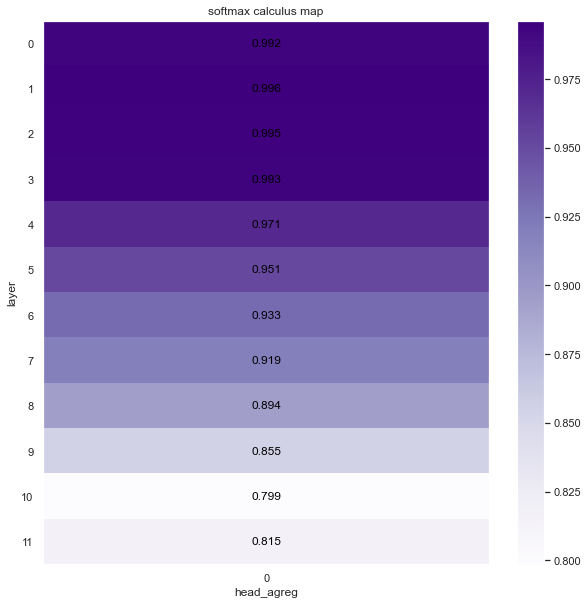

In [8]:
softmax_fig = default_plot_colormap(map = softmax_calculus/999,
                                    xlabel = "head_agreg",
                                    ylabel = "layer",
                                    title = "softmax calculus map")

plt.savefig(os.path.join(os.getcwd(),".cache","plots","entropy_study", "softmax_entropy_punctuation_less_head_agreg_map.png"))

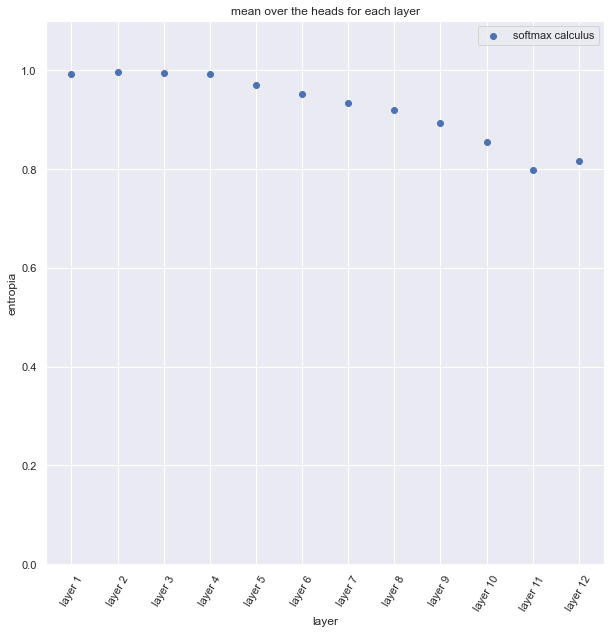

In [10]:
fig = plt.figure(figsize=(10,10))

txt = plt.title("mean over the heads for each layer")

plt.scatter(list(range(1,13)), softmax_calculus[:, 0]/999, label="softmax calculus")

plt.ylim((0, 1.1))

plt.ylabel("entropia")
plt.xlabel("layer")

x = list(range(1, 13))
plt.xticks(x, [f"layer {l}" for l in x], rotation=60)

txt = plt.legend()
plt.savefig(os.path.join(os.getcwd(),".cache","plots","entropy_study", "mean_head_agregation_entropia_scatter_punctuation_less.png"))